In [1]:
import numpy as np
import os
import PIL
import sys
from monai.networks.nets import UNETR
import matplotlib.pyplot as plt
import torch.cuda as cuda
sys.path.append("../Utils")
from utils import get_padded_loaders
import torch

c:\python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
path_train = "../../Data/dataset_DRIVE/training/images/"
training_images = os.listdir(path_train)

In [3]:
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

In [4]:
train_images['21'].shape

(584, 565, 3)

In [5]:
DEVICE = "cuda" if cuda.is_available() else "cpu"


kwargs = {'train_dir': '../../Data/dataset_DRIVE/training/images',
          'train_maskdir': '../../Data/dataset_DRIVE/training/1st_manual',
          'val_dir': '../../Data/dataset_DRIVE/validation/images',
          'val_maskdir': '../../Data/dataset_DRIVE/validation/1st_manual',
          'batch_size': 1,
          'rotation': [-45, 45],
          'hflip_prob': 0.3,
          'brightness': [0.5, 1.5],
          'contrast': [0.5, 1.5],
          'gamma': [0.7, 1.3],
          'affine_prob': 0.4,
          'affine_translate': [0.05, 0.1],  # Horiz and vert translation
          'affine_scale': [1, 1.3],
          'affine_shears': [0, 0],
          'noise': (0, 0.2),  # (Mean,std)
          'num_workers': 0,
          'pin_memory': True}

In [6]:
train_loader, val_loader = get_padded_loaders(**kwargs)

In [7]:
image = next(iter(train_loader))[0]

In [8]:
image.shape

torch.Size([1, 3, 584, 584])

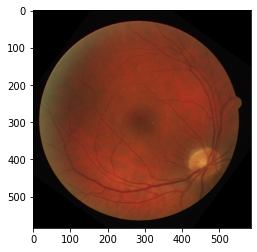

In [9]:
plt.imshow(image.squeeze(0).permute(1, 2, 0))

In [10]:
model = UNETR(in_channels=3, out_channels=1, img_size=(584, 584), spatial_dims=2, feature_size=16)

In [11]:
sum([t.numel() for t in model.parameters()])

88514545

In [12]:
model(image)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 576 but got size 584 for tensor number 1 in the list.

In [39]:
def print_shape(name, shape):
    print(f"{name}: {shape}")

class MyUNETR(UNETR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def myforward(self, x_in):
        print_shape("input size", x_in.shape)
        x, hidden_states_out = self.vit(x_in)
        print_shape("vit output", x.shape)
        print_shape("hidden states: ", set(t.shape for t in hidden_states_out))
        enc1 = self.encoder1(x_in)
        print_shape("encoder 1", enc1.shape)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2, self.hidden_size, self.feat_size))
        print_shape("encoder 2", enc2.shape)
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3, self.hidden_size, self.feat_size))
        print_shape("encoder 3", enc3.shape)
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4, self.hidden_size, self.feat_size))
        print_shape("encoder 4", enc4.shape)
        dec4 = self.proj_feat(x, self.hidden_size, self.feat_size)
        print_shape("decoder 4", dec4.shape)
        dec3 = self.decoder5(dec4, enc4)
        print_shape("decoder 3", dec3.shape)
        dec2 = self.decoder4(dec3, enc3)
        print_shape("decoder 2", dec2.shape)
        dec1 = self.decoder3(dec2, enc2)
        print_shape("decoder 1", dec1.shape)
        out = self.decoder2(dec1, enc1)
        print_shape("out", out.shape)
        return self.out(out)

In [59]:
mymodel = MyUNETR(in_channels=3, out_channels=1, img_size=576, spatial_dims=2, feature_size=16)

In [60]:
mymodel.myforward(torch.rand([1,3, 576, 576]))

input size: torch.Size([1, 3, 576, 576])
vit output: torch.Size([1, 1296, 768])
hidden states: : {torch.Size([1, 1296, 768])}
encoder 1: torch.Size([1, 16, 576, 576])
encoder 2: torch.Size([1, 32, 288, 288])
encoder 3: torch.Size([1, 64, 144, 144])
encoder 4: torch.Size([1, 128, 72, 72])
decoder 4: torch.Size([1, 768, 36, 36])
decoder 3: torch.Size([1, 128, 72, 72])
decoder 2: torch.Size([1, 64, 144, 144])
decoder 1: torch.Size([1, 32, 288, 288])
out: torch.Size([1, 16, 576, 576])


tensor([[[[ 0.0083,  0.6638, -0.1650,  ...,  0.4643, -0.4105,  0.0432],
          [ 0.0342, -1.0455, -0.6990,  ..., -0.8616,  0.2480, -0.0188],
          [-0.1364,  0.4577,  0.5148,  ...,  0.0146, -0.8048,  0.2187],
          ...,
          [ 0.5953, -0.1606, -0.4143,  ..., -0.0744, -0.3111,  0.0897],
          [ 0.0168, -0.1460,  0.0595,  ..., -0.5207, -1.0881,  0.1659],
          [ 0.2755, -0.1069, -0.4457,  ..., -0.2819,  0.1183, -0.0279]]]],
       grad_fn=<MkldnnConvolutionBackward0>)